<a href="https://colab.research.google.com/github/sefamertgungor/tumorDetection/blob/main/Flair_t2_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Proje/BraTS2020_TrainingData.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [2]:
import numpy
import random as r
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import keras

In [3]:
pip install simpleitk

     |████████████████████████████████| 47.4MB 69kB/s 


In [4]:
yol = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [5]:
import os
os.listdir(yol)

['BraTS20_Training_022',
 'BraTS20_Training_002',
 'BraTS20_Training_038',
 'BraTS20_Training_001',
 'BraTS20_Training_009',
 'BraTS20_Training_034',
 'BraTS20_Training_007',
 'BraTS20_Training_033',
 'BraTS20_Training_017',
 'BraTS20_Training_019',
 'BraTS20_Training_040',
 'BraTS20_Training_037',
 'BraTS20_Training_026',
 'survival_info.csv',
 'name_mapping.csv',
 'BraTS20_Training_013',
 'BraTS20_Training_016',
 'BraTS20_Training_030',
 'BraTS20_Training_028',
 'BraTS20_Training_020',
 'BraTS20_Training_025',
 'BraTS20_Training_006',
 'BraTS20_Training_014',
 'BraTS20_Training_035',
 'BraTS20_Training_032',
 'BraTS20_Training_012',
 'BraTS20_Training_010',
 'BraTS20_Training_027',
 'BraTS20_Training_024',
 'BraTS20_Training_015',
 'BraTS20_Training_004',
 'BraTS20_Training_036',
 'BraTS20_Training_008',
 'BraTS20_Training_005',
 'BraTS20_Training_021',
 'BraTS20_Training_031',
 'BraTS20_Training_039',
 'BraTS20_Training_029',
 'BraTS20_Training_018',
 'BraTS20_Training_011',
 'BraTS

In [6]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random as r

def seg_array(path,end,label):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        
        if label == 1:
            img[img != 0 ] = 1 # tam tümör
        if label == 2:
            img[img != 1 ] = 0 # nekroz
        if label == 3:
            img[img == 2 ] = 0 # ödemsiz tümör
            img[img != 0 ] = 1
        if label == 4:
            img[img != 4 ] = 0 # genişleyen tümör
            img[img == 4 ] = 1
         
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
            
    return np.array(img_liste,np.float32) #!!!!!!!!


def train_array(path,end):
    files = glob.glob(path+end,recursive=True)
    img_liste = []
    r.seed(9)
    r.shuffle(files)
    for file in files:
        img = io.imread(file,plugin='simpleitk')
        img = (img-img.mean())/ img.std()
        img.astype('float32')
        
        for slice in range(60,130):
            img_s = img[slice,:,:]
            img_s = np.expand_dims(img_s,axis=0)
            img_liste.append(img_s)
    print(img_liste[0].shape)
    
    return np.array(img_liste,np.float32) #!!!!!!!!

In [7]:
flair=train_array(yol,'**/*flair.nii')
t2=train_array(yol,'**/*t2.nii')
seg = seg_array(yol,'**/*seg.nii',1)
seg_orj = seg_array(yol,'**/*seg.nii',1)
tce = train_array(yol,'**/*t1ce.nii')
t1 = train_array(yol,'**/*t1.nii')

(1, 240, 240)
(1, 240, 240)
(1, 240, 240)
(1, 240, 240)


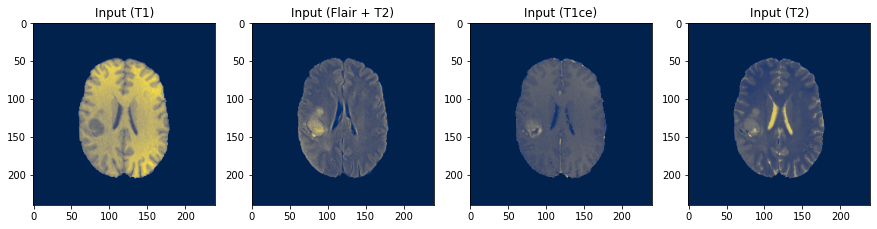

In [8]:
deger = 450
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a = 4

fig = plt.figure(figsize=(15,10))
plt.subplot(141)
plt.title('Input (T1)')
plt.imshow(t1[deger][0],cmap = renk[a])

plt.subplot(142)
plt.title('Input (Flair + T2)')
plt.imshow(flair[deger][0],cmap = renk[a])

plt.subplot(143)
plt.title('Input (T1ce)')
plt.imshow(tce[deger][0],cmap = renk[a])

plt.subplot(144)
plt.title('Input (T2)')
plt.imshow(t2[deger][0],cmap = renk[a])

In [9]:
flair.shape, seg.shape, t2.shape, tce.shape


((2800, 1, 240, 240),
 (2800, 1, 240, 240),
 (2800, 1, 240, 240),
 (2800, 1, 240, 240))

In [10]:
flair.dtype, seg.dtype, t2.dtype

(dtype('float32'), dtype('float32'), dtype('float32'))

In [11]:
x_train = np.concatenate((flair,t2),axis=1)
x_train.dtype, x_train.shape

(dtype('float32'), (2800, 2, 240, 240))

In [ ]:
x_trainn = np.concatenate((tce,tce),axis=1)
x_trainn.dtype, x_trainn.shape

(dtype('float32'), (2800, 2, 240, 240))

In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.set_image_data_format('channels_first')


def Jac(y_true, y_pred):
    y_pred_f = K.flatten(K.round(y_pred))
    y_true_f = K.flatten(y_true)
    num = K.sum(y_true_f * y_pred_f)
    den = K.sum(y_true_f) + K.sum(y_pred_f) - num
    return num / den


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def unet_model():
    
    inputs = Input((2, 240 , 240))
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = ['binary_crossentropy'], metrics = [Jac])

    return model

model = unet_model()


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


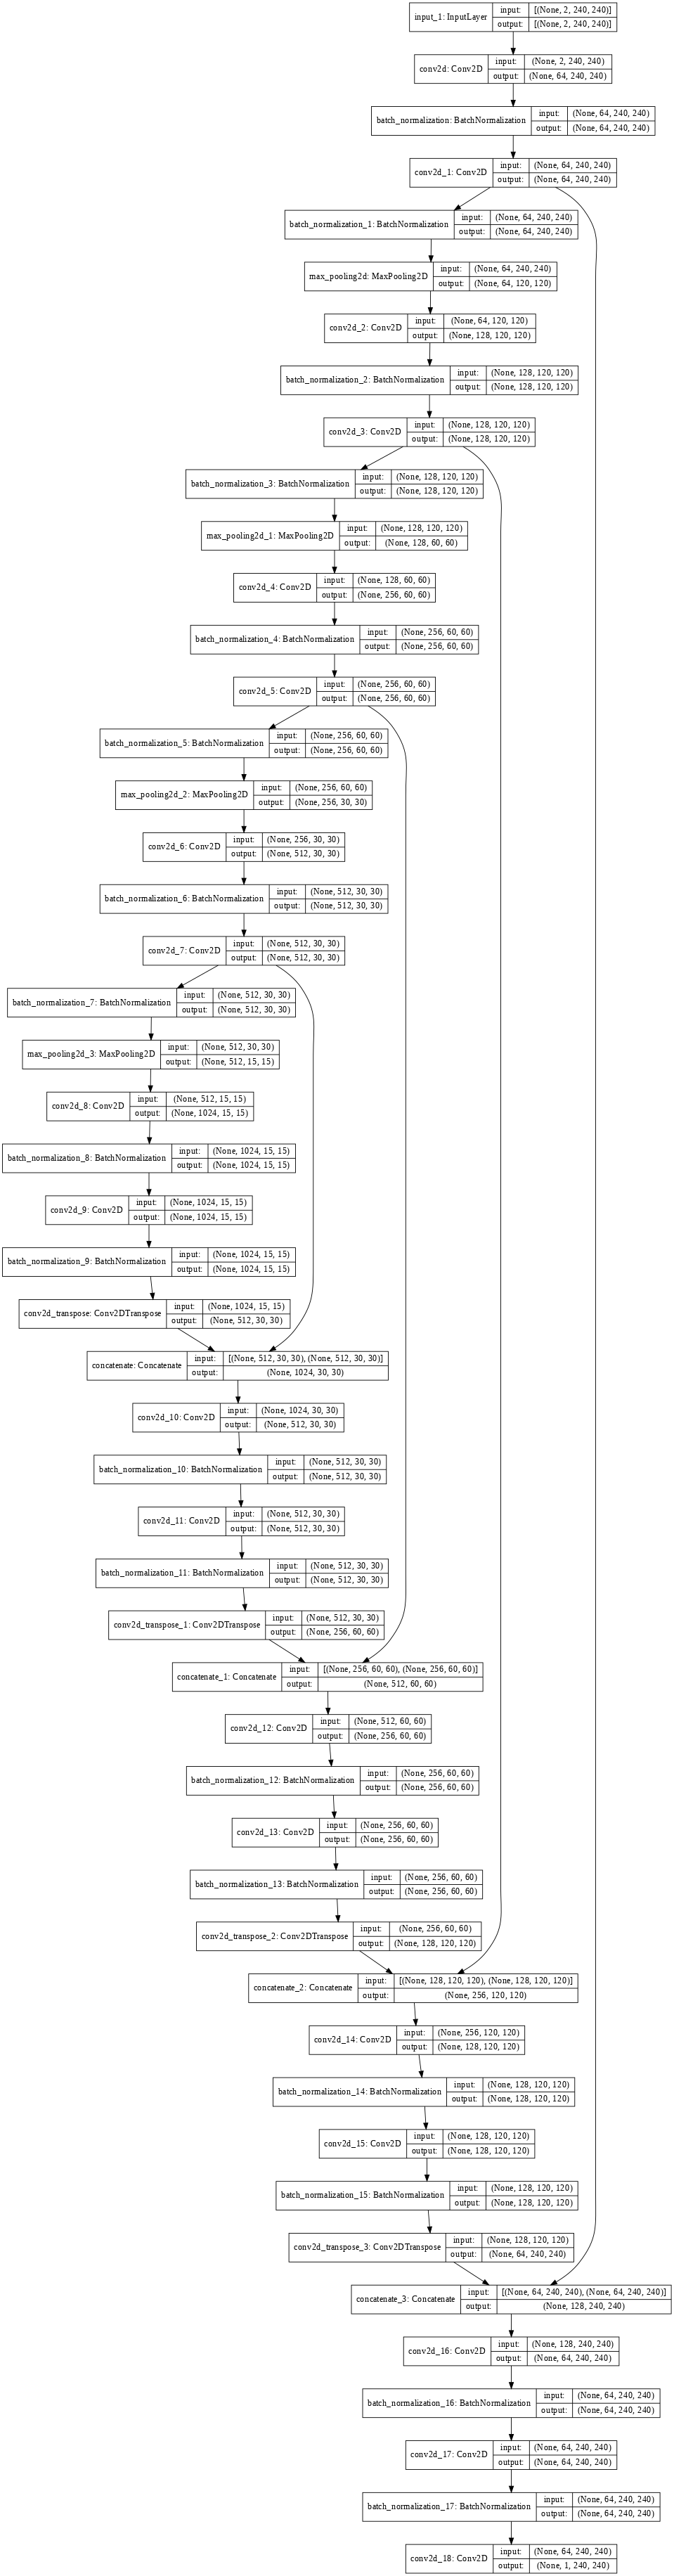

In [13]:
# Model Yapisi
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [14]:
model.fit(x_train,seg,validation_split=0.20,batch_size=10,epochs=30,shuffle=True,verbose=1)

Epoch 1/30
224/224 [==============================] - 176s 522ms/step - loss: 0.5508 - Jac: 0.3003 - val_loss: 3.5477 - val_Jac: 0.0159
Epoch 2/30
224/224 [==============================] - 116s 520ms/step - loss: 0.3467 - Jac: 0.7720 - val_loss: 0.5920 - val_Jac: 0.2492
Epoch 3/30
224/224 [==============================] - 118s 526ms/step - loss: 0.2526 - Jac: 0.8114 - val_loss: 0.2020 - val_Jac: nan
Epoch 4/30
224/224 [==============================] - 118s 526ms/step - loss: 0.1724 - Jac: 0.8492 - val_loss: 0.1256 - val_Jac: nan
Epoch 5/30
224/224 [==============================] - 116s 519ms/step - loss: 0.1297 - Jac: 0.8439 - val_loss: 0.0993 - val_Jac: nan
Epoch 6/30
224/224 [==============================] - 116s 519ms/step - loss: 0.0855 - Jac: 0.8764 - val_loss: 0.0781 - val_Jac: nan
Epoch 7/30
224/224 [==============================] - 118s 526ms/step - loss: 0.0634 - Jac: 0.8780 - val_loss: 0.0615 - val_Jac: nan
Epoch 8/30
224/224 [==============================] - 116s 519m

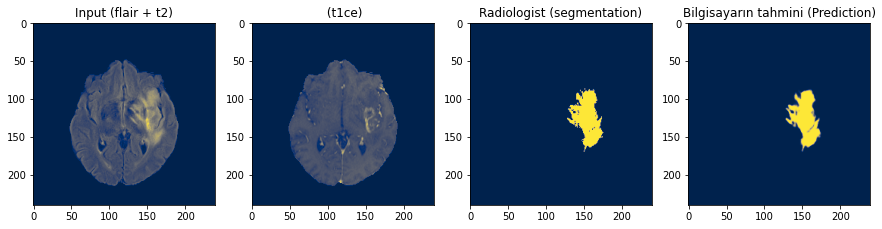

In [18]:

x    = 560
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4



örnek = np.expand_dims(x_train[x],axis=0)
pred = model.predict(örnek)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (flair + t2)')
plt.imshow(x_train[x][0],cmap = renk[a])


plt.subplot(142)
plt.title(' (t1ce)')
plt.imshow(tce[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(144)
plt.title('Bilgisayarın tahmini (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])


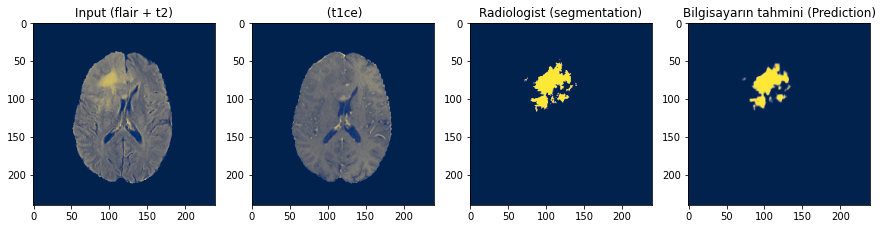

In [20]:

x    = 1000
renk = {0:'magma',
        1:'viridis',
        2:'gray',
        3:'inferno',
        4:'cividis',
        5:'hot', }
a    = 4



örnek = np.expand_dims(x_train[x],axis=0)
pred = model.predict(örnek)


fig = plt.figure(figsize=(15,10))

plt.subplot(141)
plt.title('Input (flair + t2)')
plt.imshow(x_train[x][0],cmap = renk[a])


plt.subplot(142)
plt.title(' (t1ce)')
plt.imshow(tce[x][0],cmap = renk[a])

plt.subplot(143)
plt.title('Radiologist (segmentation)')
plt.imshow( seg[x][0],cmap = renk[a])

plt.subplot(144)
plt.title('Bilgisayarın tahmini (Prediction)')
plt.imshow( pred[0][0],cmap = renk[a])